## ldist: Local neighborhood distances

In [1]:
from ipynb.fs.full.koselleck import *

[Koselleck] (07:55:51) Alles bereit 


In [16]:
INDEX_LDIST=['word1','word2','corpus1','corpus2','period1','period2']

def ldist_qstr(col1,col2,k,incl_words):
    return f"{col1}/{col2}/k={k}/incl_words={incl_words}"

def ldist_word_qstr(word,ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,k=K,
                    corpus=DEFAULT_CORPUS):
    return f'{word}/{corpus}/{ymin}-{ymax}_{ybin}|'

def ldist(word_or_words, all_periods=False, **ldist_iter_opts):
    l=[res for res in ldist_iter(word_or_words, **ldist_iter_opts)]
    odf=pd.concat(l) if len(l) else pd.DataFrame()
    if len(odf) and all_periods:
        odf=odf.reset_index()
        odf=odf.append(odf.assign(period1=odf.period2, period2=odf.period1))
        odf=odf.set_index(INDEX_LDIST).sort_index()
    return odf

def ldist_iter(word_or_words, force=False, num_proc=1,
               ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,k=K,
               corpus=DEFAULT_CORPUS,commit_byword=False,progress=True,cache=True,
               **ldist_word_opts):
    objs=[
        dict(word=w, force=force, progress=False, num_proc=1,# if commit_byword else num_proc,
             commit=not commit_byword, return_dict=False, qstr=ldist_word_qstr(
                w,ymin=ymin,ymax=ymax,ybin=ybin,k=k,corpus=corpus
             ), **ldist_word_opts)
        for w in to_words(word_or_words)
    ]
    
    iterr=pmap_iter(
        ldist_word_,
        objs,
        num_proc=num_proc,#1 if not commit_byword else num_proc,
        progress=progress if len(objs)>1 else False,
        kwargs=dict(ymin=ymin,ybin=ybin,ymax=ymax,k=k,commit=cache,progress=progress if len(objs)==1 else False)
    )
        #for i,dbd in enumerate(iterr):
        #    for qstr,odx in dbd.items(): db[qstr]=odx
        #    if i and not i%100: db.commit()
        #    odf=pd.DataFrame(dbd.values())
    
    if commit_byword:
        with get_db('ldist',mode='c') as db:
            for i,(obj,odf) in enumerate(zip(objs,iterr)):
                if odf is not None and len(odf):
                    db[obj['qstr']]=odf
                    yield odf
                if i and not i%10: db.commit()
            db.commit()
    else:
        yield from iterr
    
def ldist_word_(objd, **attrs):
    o={**objd, **attrs}
    return ldist_word(**o)
def ldist_word(word,
               k=K,
               incl_words=False,
               force=False,
               progress=True,
               num_proc=1,
               ybin=YBIN_DISTMAT,
               ymin=YMIN_DISTMAT,
               ymax=YMAX_DISTMAT,
               return_dict=False,
               commit=True,
               **wdist_opts):
    dfdist=wdist(word, ybin=ybin, ymin=ymin, ymax=ymax, **wdist_opts)
    l=[]
    qcols=[
        (col1,col2,ldist_qstr(col1,col2,k,incl_words))
        for col1 in dfdist.columns for col2 in dfdist.columns if col1<col2
    ]
    dbdone,dbqueue={},{}
    if force or not commit:
        ql=qcols
    else:
        with get_db('ldist',mode='r') as db:
            for q in qcols:
                if q[-1] in db:
                    dbdone[q[-1]]=db[q[-1]]
            ql=[q for q in qcols if not q[-1] in dbdone]
    
    if len(ql):
        objs = [
            (dfdist[col1],dfdist[col2],k,incl_words)
            for col1,col2,qstr in ql
        ]
        
        iterr = pmap_iter(do_ldist, objs, num_proc=num_proc, progress=progress)
        for (col1,col2,qstr),odx in zip(ql,iterr):
            odx['word1'],odx['corpus1'],odx['period1']=col1.split('_')
            odx['word2'],odx['corpus2'],odx['period2']=col2.split('_')
            dbqueue[qstr]=odx
        iterr.close()
        
        if commit:
            with get_db('ldist',mode='c') as db:
                for qstr,odx in dbqueue.items():
                    db[qstr]=odx
                db.commit()
    
    dbd={**dbdone, **dbqueue}
    if return_dict: return dbd
    odf=pd.DataFrame(dbd.values())
    if len(odf): odf=odf.set_index(INDEX_LDIST).sort_index()
    return odf
    
    
    
    
    
def do_ldist(obj):
    w,s1,s2,k,incl_words=obj
    s1,s2=s1.dropna(),s2.dropna()
    valid_words_now=set(s1.index) & set(s2.index)
    s1=s1.loc[valid_words_now].sort_values()
    s2=s2.loc[valid_words_now].sort_values()

    # get top words for each
    nb1=s1.iloc[:k].index
    nb2=s2.iloc[:k].index

    # get meta neighborhoods
    mnb=list(set(nb1)|set(nb2))
    nb1s=s1.loc[mnb]
    nb2s=s2.loc[mnb]

    # try to get distance
    try:
        #print(f'Computing: {col1} vs {col2}')
        distdists = 1-fastdist.cosine(nb1s.values.astype(float), nb2s.values.astype(float))
    except ZeroDivisionError as e:
        distdists=np.nan

    # return dict as df
    nb1str=', '.join(f'{"-" if x not in set(nb2) else ""}{x}' for x in nb1)
    nb2str=', '.join(f'{"+" if x not in set(nb1) else ""}{x}' for x in nb1)
    odx={
        'word':w,
        'dist':distdists,
        'mneighb_size':len(mnb),
        'neighb1_size':len(nb1),
        'neighb2_size':len(nb2),
        'neighb1':nb1str,
        'neighb2':nb2str,
        'mneighb':', '.join(mnb),
    }
    return odx

In [17]:
# # wl=random.sample(get_valid_words(),3)
# wl=get_valid_words()
# for odf in ldist_iter(wl,ymin=1680,ymax=1960,num_proc=4):
#     #display(odf)
#     #break
#     pass

In [18]:
# stop

In [19]:
# w=random.choice(get_valid_words())
# ldist(w,ybin=20,all_periods=True)

In [25]:
def _do_ldist_(obj):
    return (obj,do_ldist(obj))

def ldist_periods(period1,period2,words=get_valid_words(),k=K,incl_words=False,
                num_proc=1,progress=True,force=False):
    key=f'periods/{period1}/{period2}/{lltk.hashstr(str(sorted(words)))[:10]}/k={k}__incl_words={incl_words}'
    odf=None
    if not force:
        with get_db('ldist') as db:
            if key in db: odf=db[key]
    
    if odf is None:
        dfdist1=vdist(period1)
        dfdist2=vdist(period2)

        cols1=set(dfdist1.columns)
        cols2=set(dfdist2.columns)
        objs = [
            (w,dfdist1[w],dfdist2[w],k,incl_words)
            for w in (set(words)&set(cols1)&set(cols2))
        ][:100]
        iterr = pmap_iter(_do_ldist_, objs, num_proc=num_proc, progress=progress)
        odf = pd.DataFrame(x[1] for x in iterr if x and len(x))
        odf['period1'],odf['period2']=period1,period2
        if not incl_words: odf=odf.drop(['neighb1','neighb2'],axis=1)
        odf=odf.set_index(['word','period1','period2'])
        with get_db('ldist','w') as db: db[key]=odf

    odf['dist_rank']=odf['dist'].rank(ascending=False).apply(int)
    odf['dist_perc']=((odf['dist'].rank() / len(odf)) * 100).apply(int)
    return odf.sort_values('dist_perc',ascending=False)
    return odf
    

In [ ]:
odf=ldist_periods('1700-1770','1830-1900',num_proc=1,incl_words=True,force=True)
odf

Mapping _do_ldist_() [x1]:  33%|███▎      | 33/100 [00:00<00:00, 107.16it/s]

## Speed of change

In [109]:
def is_bef_aft(row): return row.period2.split('-')[0] == row.period1.split('-')[-1]

In [122]:
def speed_word(
        word,
        ymin=YMIN_NBR,
        ymax=YMAX_NBR,
        ybin=YBIN_NBR,
        **ldist_opts):
    dists=ldist(
        word,
        ymin=ymin,ymax=ymax,ybin=ybin,
        all_periods=True,
        **ldist_opts
    ).reset_index()
    odf = dists[dists.apply(is_bef_aft,axis=1)]
    odf['period']=[int(x[:4]) for x in odf['period2']]
    return odf

def speed(words, **opts):
    return pd.concat(speed_word(w,**opts) for w in to_words(words))

In [123]:
dfspd=speed_word('liberal',ybin=20,ymin=1720,ymax=1960)
dfspd

,word1,word2,corpus1,corpus2,period1,period2,dist,mneighb_size,neighb1_size,neighb2_size,neighb1,neighb2,period
0,liberal,liberal,bpo,bpo,1720-1740,1740-1760,0.029263,17,10,10,,,1740
12,liberal,liberal,bpo,bpo,1740-1760,1760-1780,0.024336,18,10,10,,,1760
24,liberal,liberal,bpo,bpo,1760-1780,1780-1800,0.008416,14,10,10,,,1780
36,liberal,liberal,bpo,bpo,1780-1800,1800-1820,0.013055,12,10,10,,,1800
48,liberal,liberal,bpo,bpo,1800-1820,1820-1840,0.018743,13,10,10,,,1820
60,liberal,liberal,bpo,bpo,1820-1840,1840-1860,0.012428,13,10,10,,,1840
72,liberal,liberal,bpo,bpo,1840-1860,1860-1880,0.035212,18,10,10,,,1860
84,liberal,liberal,bpo,bpo,1860-1880,1880-1900,0.027377,14,10,10,,,1880
96,liberal,liberal,bpo,bpo,1880-1900,1900-1920,0.013325,11,10,10,,,1900
108,liberal,liberal,bpo,bpo,1900-1920,1920-1940,0.033235,13,10,10,,,1920


In [124]:
speed('liberal,liberty')

,word1,word2,corpus1,corpus2,period1,period2,dist,mneighb_size,neighb1_size,neighb2_size,neighb1,neighb2,period
0,liberal,liberal,bpo,bpo,1720-1740,1740-1760,0.029263,17,10,10,,,1740
12,liberal,liberal,bpo,bpo,1740-1760,1760-1780,0.024336,18,10,10,,,1760
24,liberal,liberal,bpo,bpo,1760-1780,1780-1800,0.008416,14,10,10,,,1780
36,liberal,liberal,bpo,bpo,1780-1800,1800-1820,0.013055,12,10,10,,,1800
48,liberal,liberal,bpo,bpo,1800-1820,1820-1840,0.018743,13,10,10,,,1820
60,liberal,liberal,bpo,bpo,1820-1840,1840-1860,0.012428,13,10,10,,,1840
72,liberal,liberal,bpo,bpo,1840-1860,1860-1880,0.035212,18,10,10,,,1860
84,liberal,liberal,bpo,bpo,1860-1880,1880-1900,0.027377,14,10,10,,,1880
96,liberal,liberal,bpo,bpo,1880-1900,1900-1920,0.013325,11,10,10,,,1900
108,liberal,liberal,bpo,bpo,1900-1920,1920-1940,0.033235,13,10,10,,,1920


In [125]:
def plot_speed(word_or_words, **opts):
    dfspd=speed(word_or_words,**opts).query('word1==word2')
    dfspd['word']=dfspd['word1']
    
    fig=start_fig(
        dfspd,
        x='period',
        y='dist',
        color='word',
        shape='word',
        figure_size=(8,5)
    )
    fig+=p9.geom_line()
    fig+=p9.geom_point()
    fig+=p9.scale_color_gray()
    return fig

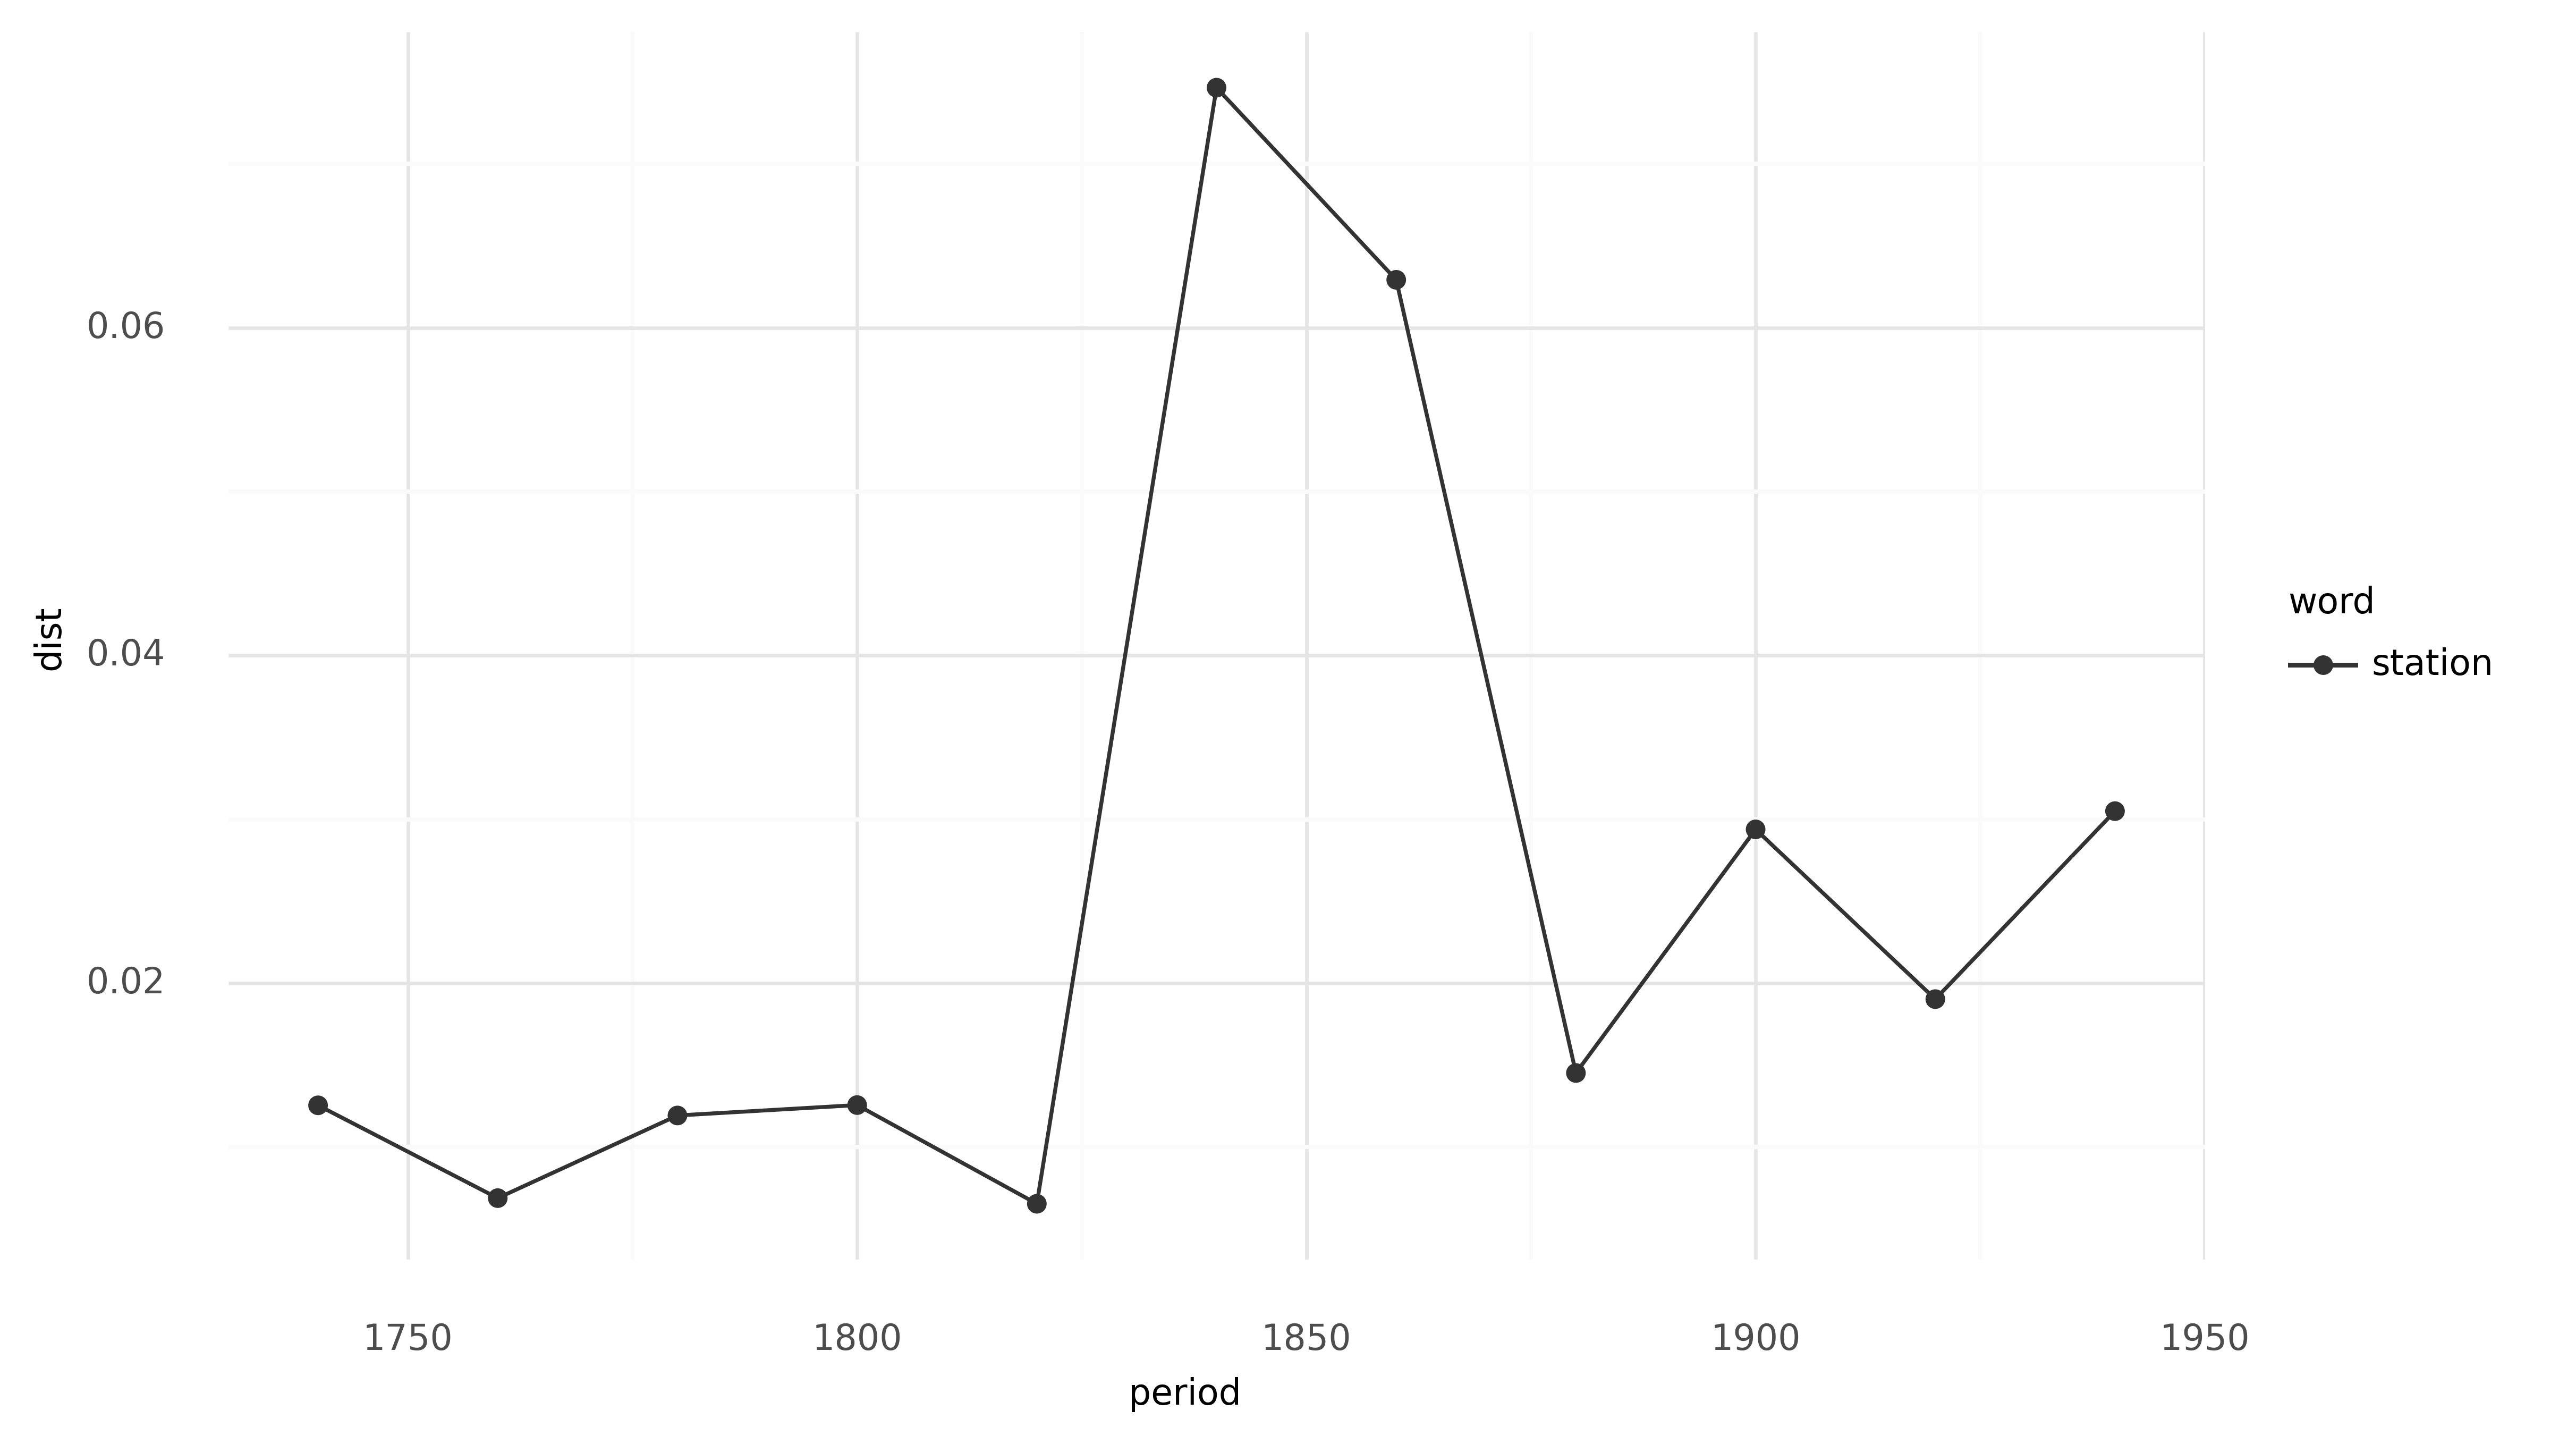

<ggplot: (8751223534836)>

In [128]:
plot_speed(
    'station',
    ymin=1720,ymax=1960,ybin=20
)

In [119]:
res=interact_manual_plot(plot_speed, word_or_words='liberal,liberty')

interactive(children=(Text(value='liberal,liberty', description='word_or_words'), Button(description='Plot', s…

In [87]:
dmatkeys=db_get_keys('distmat')
wordsnow=list({w.split('/')[0] for w in dmatkeys})

In [45]:
# %%timeit
# w=random.choice(wordsnow)
# ldist(w).dist.mean()

## Averaging all distances

In [46]:
x=db_get_keys('distmat')
# x

In [76]:
def get_avg_selfdists(ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,k=K,force=False):
    qstr_suf = f'{ymin}-{ymax}_{ybin}/k={k}'
    qstr=f'_selfdists_/{qstr_suf}'
    o={}
    with get_db('distmat') as db:
        if not force and qstr in db: return db[qstr]
        for k in tqdm(db):
            if k.endswith(qstr_suf) and not k.startswith('_'):
                w=k.split('/')[0]
                o[w]=db[k].mean().mean()
            
    odf=pd.DataFrame({'selfdist':o}).rename_axis('word')
    odf['selfdist_perc']=odf.selfdist.rank() / len(odf) * 100
    odf['selfdist_rank']=odf.selfdist.rank(ascending=False).apply(int)
    odf=odf.sort_values('selfdist_rank')
    with get_db('distmat','w') as db: db[qstr]=odf
    return odf

In [78]:
sddf=get_avg_selfdists(force=True)
sddf

100%|██████████| 46872/46872 [00:15<00:00, 3075.16it/s] 


,selfdist,selfdist_perc,selfdist_rank
word,,,
suede,0.293835,100.000000,1
satin,0.291075,99.993563,2
trimmed,0.270522,99.987125,3
premiere,0.255158,99.980688,4
factor,0.254041,99.974250,5
...,...,...,...
age,0.029732,0.032187,15530
february,0.028445,0.025750,15531
called,0.028190,0.019312,15532


In [70]:
# sddf.loc['liberty']